In [ ]:
import warnings
import pandas as pd
import logging

# !!!!!!!
# for numpy >= 2.0.0 pipeline is very fast
# but catboost only works with numpy <= 1.26.x

from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler


from config import RANDOM_STATE, ModelConfig, ScoringConfig
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
plt.style.use("ggplot")


from utils import (
    list_unique_object_values,
    preprocess_medical_data,
    missing_values_stats,
    binarize_decision_class,
    full_pipeline,
)

### AP

In [2]:
df = pd.read_excel(
    "data/ap_pro_data.xls", sheet_name="Physicians - Continuous", skiprows=2
)

In [3]:
list_unique_object_values(df)

Sex ['female' 'male']
PainDur [144 120 11 24 3 32 48 96 5 72 20 7 4 12 2 9 10 60 1 8 168 216 192 6 1.5
 36 3.5 30 38 23 15 29 2.5 4.5 18 35 22 16 13 28 14 45 6.5 5.2 6.2 84 17
 '?' 108 51 0.5 15.5 5.5 240]
PainSite ['lower_abdomen' 'other' 'RLQ']
PainType ['constant' 'intermittent' '?']
Vomiting ['yes' 'no' '?']
PrevVis ['no' 'yes' '?']
Temp [37.4 35.7 35.9 37.8 38.2 37.3 37.5 38.4 37.6 36.3 38 38.3 37.1 37.2 35.6
 38.1 36.2 36.4 38.8 35.4 36.7 35.8 36 38.6 36.5 38.9 36.9 35.5 38.7 35.3
 36.6 39.8 36.1 37.7 36.8 40 35.2 37 '?' 35 35.1 37.9 39.9 39.7 39 39.6
 40.3 38.5 39.1 39.5 34.8 39.4]
TendSite ['lower_abdomen' 'other' 'RLQ' '?']
Guard ['no' 'yes' '?']
RebTend ['no' 'yes' '?']
PainShift ['no' 'yes' '?']
WBC ['?' 18.6 17 9.8 13.3 5.9 6.9 7.2 6.6 4.9 20 13.1 7.6 5.6 10.7 15.9 9.3
 3.6 4.6 10.2 2.3 14.3 9.7 20.3 14 31.6 11.2 6.8 7.8 11.9 9.6 23 10.6 14.1
 7.7 16.6 11.6 7.5 13.2 4.1 16.2 28 10.3 22.8 17.2 13 10.9 10.4 23.2 2.7
 11.1 15 19.7 8.3 7.4 11.7 21 9 4.4 7.3 6.1 10 25.3 16.3 12.

In [4]:
missing_values_stats(df.replace("?", None))

           Missing Values  Percentage
WBC                   354   77.461707
TendSite               55   12.035011
PainShift               9    1.969365
Temp                    7    1.531729
PrevVis                 5    1.094092
RebTend                 5    1.094092
PainType                4    0.875274
Vomiting                4    0.875274
Guard                   3    0.656455
PainDur                 1    0.218818


In [5]:
target_column = "Triage"
yes_no_features = ["Vomiting", "Guard", "RebTend", "PrevVisPainShift"]
onehot_features = [
    "Sex",
    "PainSite",
    "PainType",
]
num_features = [
    "Temp",
    "PainDur",
]

drop_features = ["VisitID", "RecordID", "Observer", "WBC"]  # WBC is 77.461707% NaN
cat_features = []
ordinal_features = []
keep_features = []


X, y = preprocess_medical_data(
    df,
    target_column=target_column,
    num_features=num_features,
    onehot_features=onehot_features,
    yes_no_features=yes_no_features,
    drop_features=drop_features,
    cat_features=cat_features,
    ordinal_features=ordinal_features,
    keep_features=keep_features,
)

In [6]:
y.unique()

array(['discharge', 'consult', 'observation'], dtype=object)

In [7]:
class_sequence = {"discharge": 0, "consult": 1, "observation": 2}
y = y.map(class_sequence)

2025-03-30 16:13:39,560 - SuperClassifier - INFO - Evaluating Baseline...
2025-03-30 16:13:39,560 - SuperClassifier - INFO - Evaluating Baseline...
2025-03-30 16:13:39,562 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 16:13:39,562 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 16:13:39,879 - SuperClassifier - INFO -   CV Score: 0.5654 ± 0.0630
2025-03-30 16:13:39,879 - SuperClassifier - INFO -   CV Score: 0.5654 ± 0.0630
2025-03-30 16:13:39,884 - SuperClassifier - INFO -   Test Score: 0.5851
2025-03-30 16:13:39,884 - SuperClassifier - INFO -   Test Score: 0.5851
2025-03-30 16:13:39,891 - SuperClassifier - INFO - Evaluating Target...
2025-03-30 16:13:39,891 - SuperClassifier - INFO - Evaluating Target...
2025-03-30 16:13:39,897 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 16:13:39,897 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 16:13:56,668 - SuperClassifier - INFO -   CV Score: 0.5871 ± 0.0310
2025-03-30 16:13:56,668

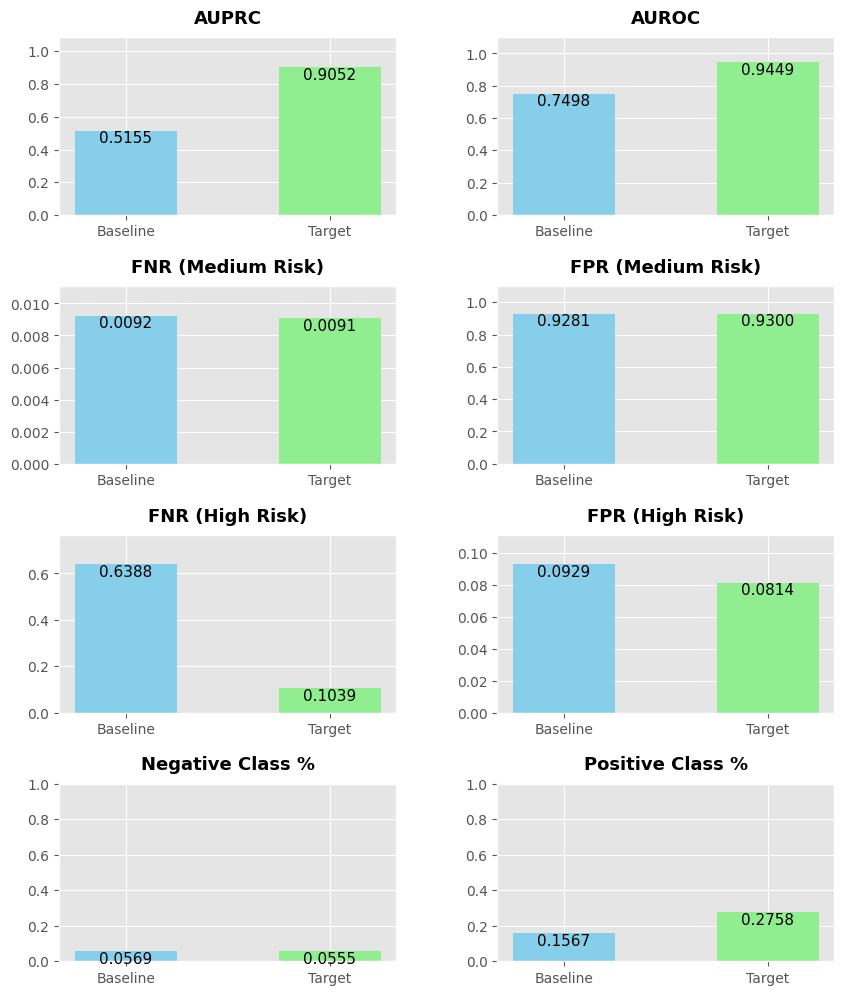

2025-03-30 16:13:59,881 - ClassifierEvaluation - INFO - Results plot saved as 'ROBUST_CATBOOST.png'


In [8]:
y_binary = binarize_decision_class(y)

baseline_config = ModelConfig(
    name="Baseline",
    estimator_class="sklearn.linear_model.LogisticRegression",
    params={"random_state": RANDOM_STATE, "max_iter": 1000},
    scoring=ScoringConfig(func=roc_auc_score, kwargs={}),
)

target_name = "ROBUST_CATBOOST"
target_config = ModelConfig(
    name="Target",
    estimator_class="sklearn.pipeline.Pipeline",
    params={
        "steps": [
            ("scaler", RobustScaler()),
            (
                "classifier",
                CatBoostClassifier(
                    iterations=1000,
                    learning_rate=0.1,
                    depth=6,
                    random_state=RANDOM_STATE,
                    verbose=0,  # Suppress CatBoost's internal logging
                ),
            ),
        ]
    },
    scoring=ScoringConfig(func=roc_auc_score, kwargs={}),
)

_, _ = full_pipeline(
    X=X,
    y=y,
    target_config=target_config,
    baseline_config=baseline_config,
    target_name=target_name,
)

### HP

In [9]:
df = pd.read_excel(
    "data/hp_retro_data.xls", sheet_name="Continouos Data (Final)", skiprows=2
)

In [10]:
list_unique_object_values(df)

SEX ['FEMALE' 'MALE']
TEMP ['?' 37.6 35.9 36.3 37.1 37.2 37 36.8 37.4 37.3 36.7 36.5 36.4 35.5 36
 36.9 38.4 37.5 35.6 37.7 37.9 36.6 34.1 36.1 38.8 39.1 38 35.8 38.3 36.2
 35.4 39.3 39.5 35 38.2 39.4 38.5 35.7 38.1 37.8 38.7 38.6 39.2 39.8 40.2
 40.4]
HEART_RATE [96 126 '?' 80 88 95 82 79 102 97 108 86 74 84 115 90 78 71 100 93 129 112
 51 73 94 101 111 132 120 92 70 107 109 81 72 64 116 114 148 140 91 103 98
 105 99 87 104 110 89 136 106 153 118 130 124 122 135 150 134 123 128 137
 113 50 76 142 121 144 60 127 117 67 58 125 119 160 61 180 66 163]
PREV_VISIT ['?' 'YES' 'NO']
HX_TRAUMA ['NO' '?' 'YES']
COMPLAINT_SITE ['HIP' 'LEG' '?' 'OTHER' 'BACK']
HX_ILLNESS ['NO' '?' 'YES']
GAIT_REPORTED ['NOT_WT_BEAR' '?' 'NORMAL' 'LIMP']
DURATION [0.06 0.5 7 1 2 14 0.6 0.21 0.75 '?' 0.29 4 0.25 0.17 60 10 6 0.041 42
 0.67 0.33 21 3 0.88 0.71 0.47 28 3.5 30 1.42 5 0.46 0.73 0.36 0.42 0.65
 1.5 0.38 0.875 0.58 0.083 0.79 0.23 0.92 2.5 0.16 90 11 0.35 0.83 4.5
 0.19 0.1 0.08 0.125 0.0625 0.52 8 0.375

In [11]:
missing_values_stats(df.replace("?", None))

                 Missing Values  Percentage
HIP_REST                    339   82.281553
PREV_VISIT                  279   67.718447
ESR                         250   60.679612
WBC                         241   58.495146
SWELLING                    150   36.407767
PREV_PROBLEMS               122   29.611650
GAIT_OBSERVED               122   29.611650
PAIN_PALPATION              120   29.126214
OTHER_PAIN_SITE             119   28.883495
HX_TRAUMA                    94   22.815534
HIP_FLEXION                  81   19.660194
PAIN_ROM_HIP                 80   19.417476
TEMP                         80   19.417476
APPEARANCE                   79   19.174757
HIP_INT_ROT                  71   17.233010
GAIT_REPORTED                56   13.592233
CURRENT_ILLNESS              51   12.378641
HX_ILLNESS                   45   10.922330
HIP_ROM                      37    8.980583
HEART_RATE                   27    6.553398
DURATION                     11    2.669903
COMPLAINT_SITE                7 

In [12]:
target_column = "TRIAGE"
num_features = ["TEMP", "HEART_RATE", "DURATION", "WBC", "ESR", "AGE"]
drop_features = ["NUMBER", "HIP_REST"]  # HIP REST 83% NaN
cat_features = [
    "SEX",
    "PREV_VISIT",
    "HX_TRAUMA",
    "COMPLAINT_SITE",
    "HX_ILLNESS",
    "GAIT_REPORTED",
    "APPEARANCE",
    "HIP_ROM",
    "HIP_INT_ROT",
    "HIP_FLEXION",
    "GAIT_OBSERVED",
    "PAIN_ROM_HIP",
    "OTHER_PAIN_SITE",
    "PAIN_PALPATION",
    "SWELLING",
    "CURRENT_ILLNESS",
    "PREV_PROBLEMS",
]
onehot_features = [
    "SEX",
    "HX_TRAUMA",
    "HX_ILLNESS",
    "PAIN_ROM_HIP",
    "SWELLING",
    "CURRENT_ILLNESS",
    "PREV_PROBLEMS",
    "PREV_VISIT",
    "COMPLAINT_SITE",
    "OTHER_PAIN_SITE",
    "PAIN_PALPATION",
]
ordinal_features = [
    "GAIT_REPORTED",
    "APPEARANCE",
    "HIP_ROM",
    "HIP_INT_ROT",
    "HIP_FLEXION",
    "GAIT_OBSERVED",
]
yes_no_features = [
    "PREV_VISIT",
    "HX_TRAUMA",
    "HX_ILLNESS",
    "PAIN_ROM_HIP",
    "CURRENT_ILLNESS",
    "PREV_PROBLEMS",
    "SWELLING",
]
ordinal_features = [
    "GAIT_REPORTED",
    "APPEARANCE",
    "HIP_ROM",
    "HIP_INT_ROT",
    "HIP_FLEXION",
    "GAIT_OBSERVED",
]
keep_features = []


X, y = preprocess_medical_data(
    df=df,
    target_column=target_column,
    num_features=num_features,
    onehot_features=onehot_features,
    yes_no_features=yes_no_features,
    drop_features=drop_features,
    cat_features=cat_features,
    ordinal_features=ordinal_features,
    keep_features=keep_features,
)

/home/kamil/Desktop/uni/SEM_10/siwim/utils.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[feature] = X[feature].replace(


In [13]:
class_sequence = {"DISCHARGE": 0, "XRAY": 1, "LAB_XRAY_BSCAN": 2}
y = y.map(class_sequence)

2025-03-30 16:14:00,219 - SuperClassifier - INFO - Evaluating Baseline...
2025-03-30 16:14:00,219 - SuperClassifier - INFO - Evaluating Baseline...
2025-03-30 16:14:00,221 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 16:14:00,221 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 16:15:22,114 - SuperClassifier - INFO -   CV Score: 0.6717 ± 0.0535
2025-03-30 16:15:22,114 - SuperClassifier - INFO -   CV Score: 0.6717 ± 0.0535
2025-03-30 16:15:22,120 - SuperClassifier - INFO -   Test Score: 0.6655
2025-03-30 16:15:22,120 - SuperClassifier - INFO -   Test Score: 0.6655
2025-03-30 16:15:22,126 - SuperClassifier - INFO - Evaluating Target...
2025-03-30 16:15:22,126 - SuperClassifier - INFO - Evaluating Target...
2025-03-30 16:15:22,132 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 16:15:22,132 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 16:15:45,389 - SuperClassifier - INFO -   CV Score: 0.6607 ± 0.0492
2025-03-30 16:15:45,389

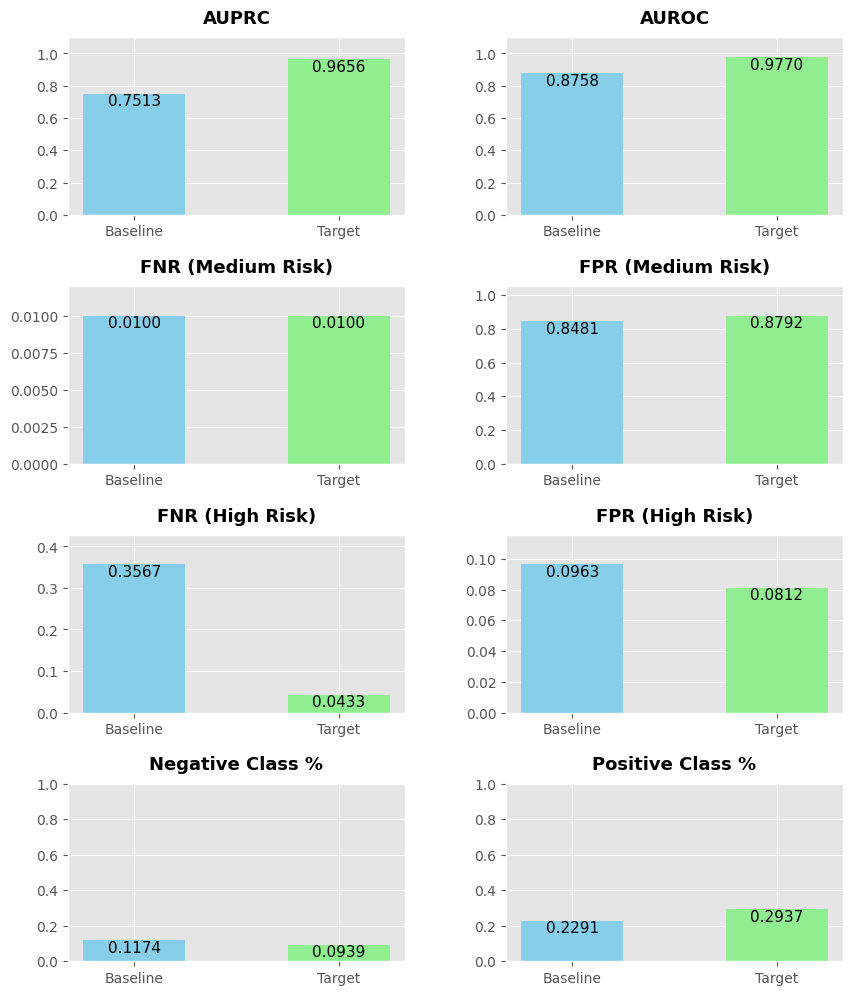

2025-03-30 16:15:49,029 - ClassifierEvaluation - INFO - Results plot saved as 'ROBUST_CATBOOST.png'


In [14]:
y_binary = binarize_decision_class(y)

baseline_config = ModelConfig(
    name="Baseline",
    estimator_class="sklearn.linear_model.LogisticRegression",
    params={"random_state": RANDOM_STATE, "max_iter": 1000},
    scoring=ScoringConfig(func=roc_auc_score, kwargs={}),
)

target_name = "ROBUST_CATBOOST"
target_config = ModelConfig(
    name="Target",
    estimator_class="sklearn.pipeline.Pipeline",
    params={
        "steps": [
            ("scaler", RobustScaler()),
            (
                "classifier",
                CatBoostClassifier(
                    iterations=1000,
                    learning_rate=0.1,
                    depth=6,
                    random_state=RANDOM_STATE,
                    verbose=0,  # Suppress CatBoost's internal logging
                ),
            ),
        ]
    },
    scoring=ScoringConfig(func=roc_auc_score, kwargs={}),
)

_, _ = full_pipeline(
    X=X,
    y=y,
    target_config=target_config,
    baseline_config=baseline_config,
    target_name=target_name,
)